### PYTORCH WORKFLOW

Cover to topic:
1. Prepare the data
2. Build model
3. Fitting the model to data (training)
4. Making prediction and evaluating a model (Inference)
5. Putting it all together


In [ ]:
import torch
from torch import nn #contain all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

## 1. DATA (PREPARING AND LOADING)

data can be almost anything... in machine learning.

*Excel spreadsheet
* Images of any kind
* Videos
* Audio like song or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data and convert into a numerical representation(tensors)
2. Build a model to learn patterns in that numerical representation

To showcase this, I will create a *known* data using the **linear regression formula**

We'll use a linear regression formula to make a straight line with known parameters.



In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02


X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len (y)

(50, 50)

In [ ]:
# Create a train/ test split

train_split = int(0.8 * len(X)) #80% of data
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

"Visualize! Visualize! Visualize!"

In [ ]:
def plot_prediction(train_data = X_train,
                    train_labels= y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):

# Plots training data, test data and compares predictions.
  plt.figure(figsize=(8, 5))

  # Plot training data in blue (train x and y)
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Purely for test data x and y
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
      # Plot prediction if it exist
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 12})

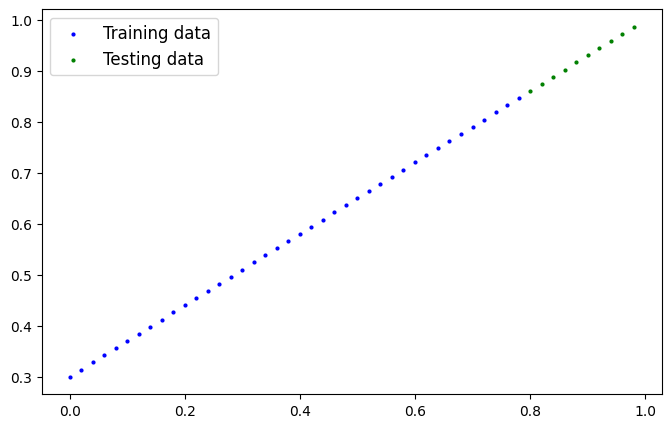

In [ ]:
plot_prediction()

## Building model

This will be my first PyTorch model

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent(or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithm:
1. Gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropogation - https://www.youtube.com/watch?v=Ilg3gGewQ5U


In [ ]:
# Create linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everthing in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  def forward(self, x: torch.Tensor) -> torch.Tensor: #overide
    return self.weights * x + self.bias #Linear regression formula




### PYTORCH MODEL BUILDSING ESSENTIALS

* torch.nn - contains all the buildings for computational graphs (Neural network are consider as computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
*torch.nn.Module - The base class for all neural network module, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient decent
*def forward() - all nn.Module subclasses require you to overwrite forward(), this method where you define the computation


## Checking the contents of our PyTorch model

Now that we created a model, lets see what's inside...
we can check the model's parameters or whats inside our model using .parameters().

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create a intance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
## list our parameters
model_0.state_dict(), #dictionary


(OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),)

### Making prediction using `torch.inference_mode()`

To check out our model's prediction power, let's see how well it predicts `y_test` based on `X_test`

When we pass data through our model, it's going to run it through the `forward()`

In [ ]:
# Make prediction with model

with torch.inference_mode(): #Diable the gradient decent and other stuff to make computation of data faster
  y_preds = model_0(X_test)

y_preds  #Because our weight and bias is randomize at the model our model wasn't able to predict the value of y_test

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
#Our target value is the value of y_test
y_test # compare to the y_preds their is still configuration we need to make our model accurate

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

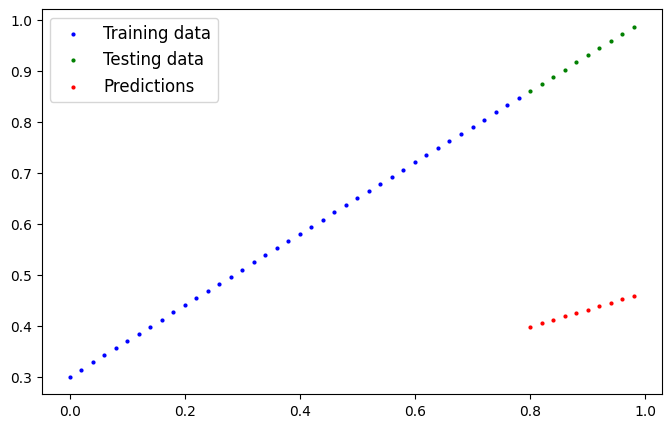

In [ ]:
plot_prediction(predictions=y_preds) #

## 3. TRAINING OUR MODEL

The goal of this training is for our model *unknown* parameter move to some known parameters.

One way to measure how poor or how wrong our models predication are, is to use PyTorch loss function.

* **NOTE:** Loss funtion can also be called cost function or criterion.

**Loss Function** is to measure how wrong your model's prediction to the ideal outputs.

**Optimizer:** Takes into account the loss function of a model and adjust the model's parameter( e.g. weight & bias ) to improve the loss function
  * Two parameters of optimizer:
      
      * params - the model parameter you'd like to optimize, for example `params=model_0.parameters()`

      * lr(learning rate) - A hyoperparameter that defines how big/small the optimizer changes the parameters with each step(a small lr result in small changes, a large lr result in large changes)


For this, we need:
* A Training loop
* A Testing loop



In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Check out our models parameters (A parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function

loss_fn = nn.L1Loss()


# Setup an optimizer  (stochastic gradient descent)

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01) #Learning rate = possible the most important hyperparameter you can set
#



### BUILDING A TRAINING AND TESTING LOOP IN PYTORCH

Steps:
0. Loop through the data
1. Forward pass (This involves moving through our model's `forward()` method) - also called forward propogation
2. Calculate the loss (compare forward pass prediction to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogation**)
5. Optimzer step - use the optimizer to adjust our model's parameter to try and improve the loss (**gradient descent**)

In [ ]:
torch.manual_seed(42)
# epochs
epochs = 180
# an epoch is one loop through the data...

#Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []



### TRAINING

# Step 0: Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() #Train mode in Py Torch set all parameters that require gradients that require gradients

  # Step 1: Forward pass
  y_preds = model_0(X_train)

  # Step 2: Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # Step 3: Optimizer zero grad
  optimizer.zero_grad()

  # Step 4: Loss backward
  loss.backward()

  # Step 5: Optimizer step
  optimizer.step()



  ### TESTING
  model_0.eval() # turn off gradient tracking

  with torch.inference_mode():
    #Step 1. Do the forward pass
    test_preds = model_0(X_test)

    #Step 2. Calculate the loss
    test_loss = loss_fn(test_preds, y_test)


  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    # Print out model state_dic()
    print(model_0.state_dict())

    #TRACK VALUE
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)


Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
#Lets plot our Traning and test loss curve
import numpy as np
def plot_loss_curve(epoch = epoch_count, train_loss = np.array(torch.tensor(loss_values).numpy()), test_loss = test_loss_values):
  plt.plot(epoch, train_loss, label="Train Loss")
  plt.plot(epoch, test_loss, label="Test Loss")
  plt.title("Training and Test Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


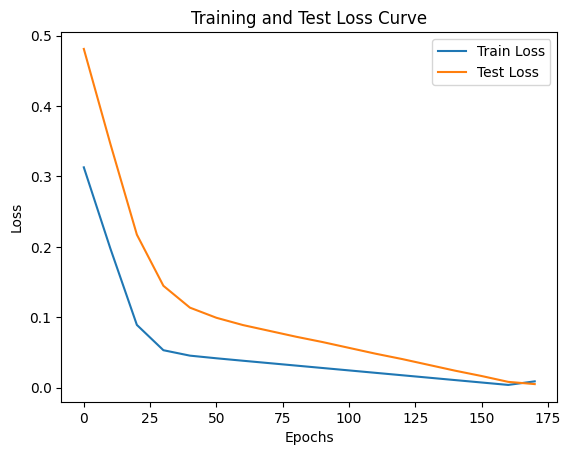

In [ ]:
plot_loss_curve()

In [ ]:
test_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
weight, bias # our target weight and bias

(0.7, 0.3)

In [ ]:
model_0.state_dict() # our model weight and bias

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

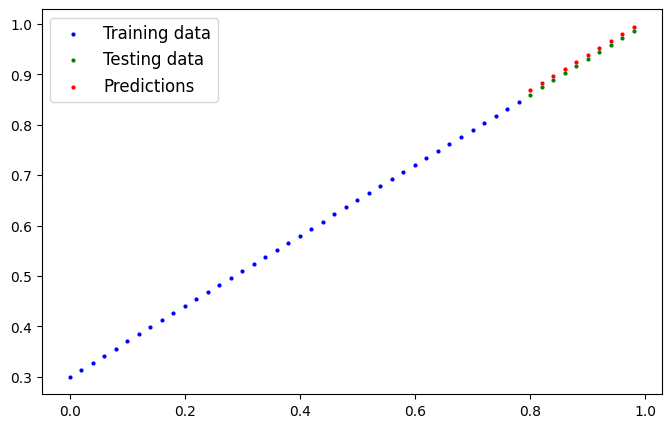

In [ ]:
plot_prediction(predictions=y_preds_new)


### SAVING A MODEL IN PYTORCH

Three main method for saving and loading model:

1. `torch.save()` - allow you to save object in Python's pickle format
2. `torch.load()` - allow you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allow you to load a model's saved state dictionary


In [ ]:
#Saving our PyTorch model

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# 2. Create model save paht
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



# 3. Save
print(f"Saving path location: {MODEL_SAVE_PATH}")

torch.save(model_0.state_dict(),
           MODEL_SAVE_PATH)



Saving path location: models/01_pytorch_workflow_model.pth


In [ ]:
!ls -l modelsyou

ls: cannot access 'modelsyou': No such file or directory


## Loading a PyTorch model

Since we save our model's `state_dict()` rather the entime model, we'll create a new instance of our model and load saved state_dict() into that.


In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instatiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()



In [ ]:
loaded_model_0.state_dict() # still has randomize parameter

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Load the save_dict of model_0 (This will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-29-7bc71a9cd3e8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some prediction with our loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# make some model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. PUTTING IT ALL TOGETHER

Go through all the steps above and put it in one place

In [ ]:
#import pytorch and matlib
import torch
from torch import nn
import matplotlib.pyplot as plt

#check pytorch version

torch.__version__

'2.5.1+cu121'

Create a device-agnostic code.

This means if we've got accessed to a GPU, the code will use it(For faster computin)

If no GPU is avaiable, default to cpu


In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * X + bias

weight = 0.6
bias = 0.4

# Create range values
start = 0
end = 1
step = 0.02

# create X and y (Features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4120],
         [0.4240],
         [0.4360],
         [0.4480],
         [0.4600],
         [0.4720],
         [0.4840],
         [0.4960],
         [0.5080]]))

In [ ]:
# Split the data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [ ]:
def plot_prediction(train_data = X_train,
                    train_labels= y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):

# Plots training data, test data and compares predictions.
  plt.figure(figsize=(8, 5))

  # Plot training data in blue (train x and y)
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Purely for test data x and y
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
      # Plot prediction if it exist
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 12})

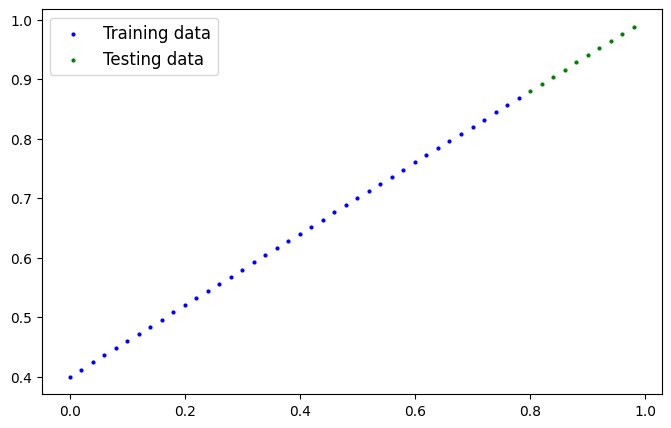

In [ ]:
plot_prediction(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

In [ ]:
#Create a Linear model

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use ss.Linear()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
#Train the model


In [ ]:
#check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
#Set the model to use the available device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

# 6.3 Training
Needed for training:

* Loss Function

* Optimizer

* Training loop

* Testing loop

In [ ]:
# SETUP
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)



In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):
  model_1.train()

  #Set data on the same device
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  # 1. forward pass
  y_preds = model_1(X_train)

  # 2. loss calculation
  loss = loss_fn(y_preds, y_train)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backpropogation
  loss.backward()

  #5. optimizer setup
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_preds = model_1(X_test)
    test_loss  = loss_fn(test_preds, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.494177907705307 | Test Loss: 0.5629762411117554
Epoch: 10 | Loss: 0.3789680600166321 | Test Loss: 0.42826637625694275
Epoch: 20 | Loss: 0.26375818252563477 | Test Loss: 0.2935565710067749
Epoch: 30 | Loss: 0.14854830503463745 | Test Loss: 0.1588466912508011
Epoch: 40 | Loss: 0.033338434994220734 | Test Loss: 0.024136889725923538
Epoch: 50 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 60 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 70 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 80 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 90 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 100 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 110 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 120 | Loss: 0.009796462021768093 | Test Loss: 0.00330507755279541
Epoch: 130 | Loss: 0.009796462021768093 | Test Loss: 0.0033050775527954

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4095], device='cuda:0'))])

In [ ]:
weight, bias

(0.6, 0.4)

# 6.4 Making and Evaluating Prediction

In [ ]:
# Turn model into eval mode
model_1.eval()

# Make prediction on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8901],
        [0.9021],
        [0.9141],
        [0.9261],
        [0.9382],
        [0.9502],
        [0.9622],
        [0.9742],
        [0.9862],
        [0.9982]], device='cuda:0')

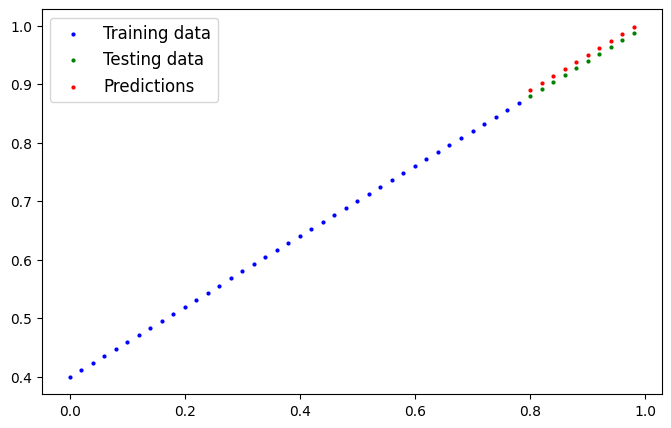

In [ ]:
# Check out our model prediciton visually
plot_prediction(predictions=y_preds.cpu())

### 6.5 SAVING & LOADING A MODEL



In [ ]:
import torch
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-51-263dd8e85800>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6007]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4095], device='cuda:0'))])

In [ ]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [ ]:
# TRAINING